# Adhoc feature map

In [1]:
import setup
from circuits import * 

from PIL import Image
from functools import reduce
import tensorflow as tf
import cv2

In [ ]:
def subsets(n):
    '''
    Subsets S of [n] where |S|<=2
    '''
    return [(i,j) for i in range(0,n) for j in range(0,n) if i != j and i<j] + [(i,) for i in range(0,n)]

def pauliprod(s,x):
    ''' 
    Pauli product of len(x) strings with Z specified by s and I elsewhere
    '''
    xs = [Z if i in s else I for i in range(len(x))]
    return reduce(lambda a,b: a^b, xs, 1)

def phi(s, x):
    '''
    Feature embedding for nqubits = 2
    '''
    if len(s)==2:
        return (np.pi - x[s[0]])*(np.pi - x[s[1]])
    else:
        return x[s[0]]

    
def U(x):
    '''
    Unitary of PauliSum operator
    '''
    
    H = 0 
    for s in subsets(len(x)):
        H = H + (phi(s,x) * pauliprod(s,x))
        
    return (-1*H).exp_i()

def fancyU(x):
    '''
    Feature map
    '''
    u = U(x)
    return u @ (H^H) @ u @ (H^H) 

def innerProduct(x1,x2):
    '''
    Transition probability of |phi(x1)> to |phi(x2)>
    '''
    Phi1 = fancyU(x1) @ Zero
    Phi2 = fancyU(x2) @ Zero

    return np.abs((~Phi2 @ Phi1).eval())**2

In [45]:
from tensorflow.keras.datasets import mnist
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [46]:
X_train, X_test= 2*np.pi*X_train/255.0 , 2*np.pi*X_test/255.0

In [66]:
train_mask = np.isin(y_train, [0])
test_mask = np.isin(y_test, [0])

In [67]:
X_train_0, y_train_0 = X_train[train_mask], y_train[train_mask]
X_test_0, y_test_0 = X_test[test_mask], y_test[test_mask]

In [72]:
train_mask = np.isin(y_train, [5])
test_mask = np.isin(y_test, [5])

In [73]:
X_train_5, y_train_5 = X_train[train_mask], y_train[train_mask]
X_test_5, y_test_5 = X_test[test_mask], y_test[test_mask]

In [99]:
compressed = [cv2.resize(x,(4,4)) for x in (list(X_train_0[:10])+list(X_train_5[:10]))]

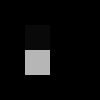

In [108]:
img = Image.fromarray(np.uint8(compressed[17]*(255/(2*np.pi))) , 'L')
display(img.resize((100, 100),  Image.NEAREST))

In [122]:
compressed[1]

array([[0.       , 0.       , 0.       , 0.       ],
       [0.       , 5.8150264, 5.987506 , 0.       ],
       [0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       ]])

In [123]:
innerProduct(compressed[1].reshape(16,),compressed[2].reshape(16,))

MemoryError: Unable to allocate 64.0 GiB for an array with shape (65536, 65536) and data type complex128

In [ ]:
K = np.array([[innerProduct(x1,x2) for x1 in X_train_sorted.to_numpy()] for x2 in X_train_sorted.to_numpy()])